# Exploratory Data Analysis

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json
import csv
import os
import cPickle as pickle
from collections import Counter

from sklearn.cluster import KMeans, SpectralClustering

import networkx as nx

from my_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

##Reading the data (stored as dataframes in pickled files)

In [2]:
# Loading the pickled data frames from users, businesses, and reviews.
# Assuming these data frames were obtained already using 'make_dataframes.py'
dataframe_pickle_filename = '../data/dataframes.pkl'
with open(dataframe_pickle_filename, 'r') as f:
    (user_df, business_df, review_df) = pickle.load(f)

## Trying to understand the data

### Looking at some overall stats

3.74265579278


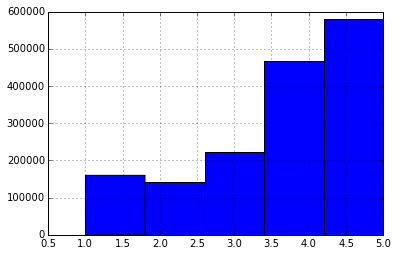

In [3]:
# average rating
print review_df.review_stars.mean()
review_df.review_stars.hist(bins=5)

Ratings are skewed toward 5.

In [4]:
# Standard deviation of the all reviews. (This will be the baseline RMSE for the whole star ratings.)
review_df.review_stars.std()

1.3114679041155461

### Find cities for businesses using k-means.

In [5]:
X = business_df[['business_latitude', 'business_longitude']].values

In [6]:
km = KMeans(10, n_jobs=8)

In [7]:
y = km.fit_predict(X)

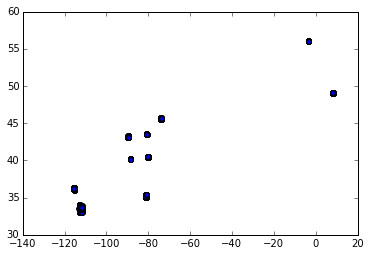

In [8]:
plt.scatter(X[:,1], X[:,0])

In [9]:
city_locations = km.cluster_centers_

In [10]:
n_businesses_per_city = Counter(y).most_common()

In [11]:
sorted_y = [c[0] for c in n_businesses_per_city]
sorted_y_map = {}                                                            
for i in range(10):                                                      
      sorted_y_map[sorted_y[i]] = i

In [12]:
business_df['business_city_int'] = map(lambda i: sorted_y_map[i], y)

In [13]:
city_names = ['Phoenix', 'Las Vegas', 'Charlotte', 'Montreal', 'Edinburgh', 'Pittsburgh',  'Madison', 'Karlsruhe',
              'Urbana-Champaign', 'Waterloo']

### Find reviews for businesses in each city

In [14]:
# Dataframe with the reviews (with business city).
review_city_df = business_df[['business_id_int', 'business_city_int']].merge(review_df, on=['business_id_int'], how='inner')

In [15]:
# Reviews for three specific cities.
review_phoenix = review_city_df[review_city_df.business_city_int == 0].drop(['business_city_int'], axis=1)   # Phoenix
review_lasvegas = review_city_df[review_city_df.business_city_int == 1].drop(['business_city_int'], axis=1)  # Las Vegas
review_charlotte = review_city_df[review_city_df.business_city_int == 2].drop(['business_city_int'], axis=1)   # Charlotte
review_montreal = review_city_df[review_city_df.business_city_int == 3].drop(['business_city_int'], axis=1)  # Montreal

In [16]:
len(review_phoenix.user_id_int.unique()), len(review_lasvegas.user_id_int.unique()),len(review_charlotte.user_id_int.unique()), len(review_montreal.user_id_int.unique()) 

(128330, 181712, 24649, 13861)

In [17]:
len(review_phoenix.business_id_int.unique()), len(review_lasvegas.business_id_int.unique()), len(review_charlotte.business_id_int.unique()), len(review_montreal.business_id_int.unique()), 

(25225, 16469, 5149, 3918)

In [18]:
review_phoenix.shape[0], review_lasvegas.shape[0], review_charlotte.shape[0], review_montreal.shape[0]

(591192, 679460, 98034, 49484)

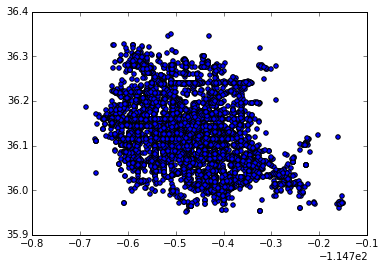

In [19]:
# Check the clustering was done correctly.
X = business_df[business_df.business_city_int==1][['business_latitude', 'business_longitude']].values
plt.scatter(X[:,1], X[:,0])

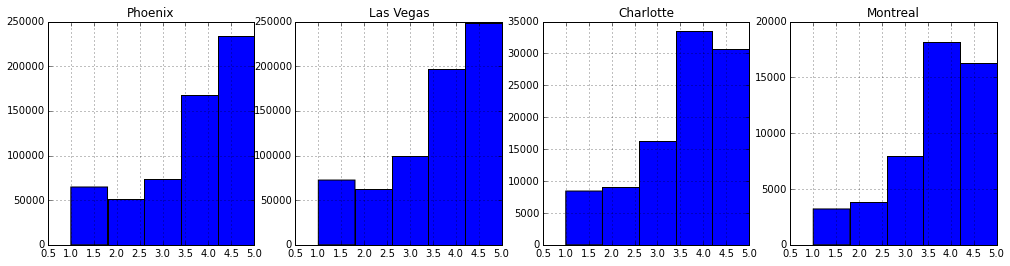

In [20]:
# Looking at review distributions in each city (Phoenix, Las Vegas, Montreal).
plt.figure(figsize = (17, 4))
plt.subplot(1,4,1)
plt.title("Phoenix")
review_phoenix.review_stars.hist(bins=5)
plt.subplot(1,4,2)
plt.title("Las Vegas")
review_lasvegas.review_stars.hist(bins=5)
plt.subplot(1,4,3)
plt.title("Charlotte")
review_charlotte.review_stars.hist(bins=5)
plt.subplot(1,4,4)
plt.title("Montreal")
review_montreal.review_stars.hist(bins=5)
plt.savefig("../fig/ratings_dist.png")

It is quite interesting that Montreal has quite different review distribution compared to other cities.

In [21]:
print review_phoenix.review_stars.std(), review_lasvegas.review_stars.std(), review_montreal.review_stars.std()

1.34162771089 1.32606119856 1.16331249085


### Number of reviews per user.

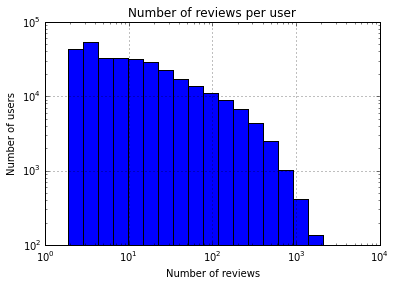

In [22]:
plt.ylim([100,100000])
plt.gca().set_xscale("log")
plt.yscale('log')
plt.title('Number of reviews per user')
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')
user_df.user_review_count.hist(bins=np.logspace(0.1, 3.5, 20))

Users have at least 1 review.

### Number of reviews per business.

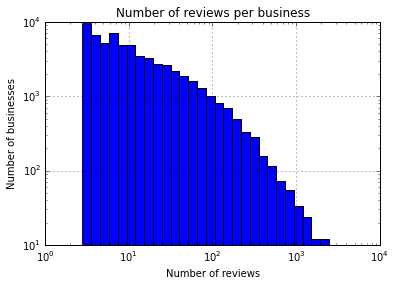

In [23]:
plt.ylim([10, 10000])
plt.gca().set_xscale("log")
plt.yscale('log')
plt.title('Number of reviews per business')
plt.xlabel('Number of reviews')
plt.ylabel('Number of businesses')
business_df.business_review_count.hist(bins=np.logspace(0.45, 3.5, 30))

In [24]:
business_df.business_review_count.min()

3

Businesses have at least 3 reviews.

### Some counts per city

In [25]:
n_users = float(user_df.shape[0])
n_businesses = float(business_df.shape[0])
n_reviews = float(review_df.shape[0])
users_by_city = np.array(review_city_df.groupby('business_city_int').user_id_int.nunique())
businesses_by_city = np.array(review_city_df.groupby('business_city_int').business_id_int.nunique())
reviews_by_city = np.array(review_city_df.groupby('business_city_int').user_id_int.count())
users_by_city_ratio = users_by_city / n_users
businesses_by_city_ratio = businesses_by_city / n_businesses
reviews_by_city_ratio = reviews_by_city / n_reviews

In [26]:
def plot_counts(users_by_city, businesses_by_city, reviews_by_city, title, ylabel, ylim=1):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ind = np.arange(10) # the x locations for the groups
    width = 0.25        # the width of the bars

    ## the bars
    rects0 = ax.bar(ind, users_by_city, width, color='r')
    rects1 = ax.bar(ind + width, businesses_by_city, width, color='g')
    rects2 = ax.bar(ind + 2 * width, reviews_by_city, width, color='b')

    # axes and labels
    ax.set_xlim(-width, len(ind) + width)
    ax.set_ylim(0, ylim)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(ind + 1.5*width)
    xtickNames = ax.set_xticklabels(city_names)
    plt.setp(xtickNames, rotation=90, fontsize=10)

    ## add a legend
    ax.legend((rects0[0], rects1[0], rects2[0]), ('Users', 'Business', 'Review'))

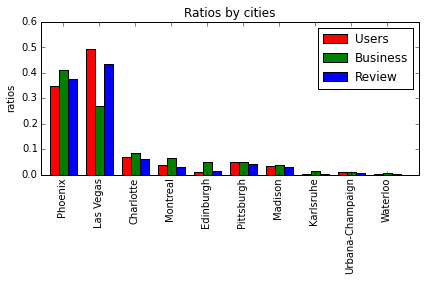

In [27]:
plt.figure(num=None, figsize=(8, 5), dpi=200)
plot_counts(users_by_city_ratio, businesses_by_city_ratio, reviews_by_city_ratio, 'Ratios by cities', 
            'ratios', ylim=0.6)
plt.tight_layout()
plt.savefig('../fig/ratios_by_city.png', dpi=200)

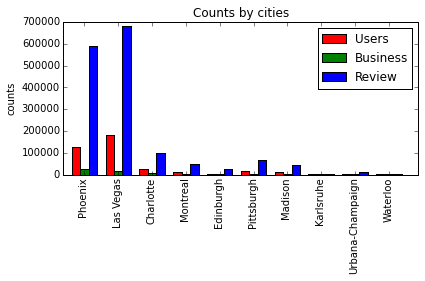

In [28]:
plt.figure(num=None, figsize=(8, 5), dpi=200)
plot_counts(users_by_city, businesses_by_city, reviews_by_city, 'Counts by cities', 
            'counts', ylim=700000)
plt.tight_layout()
plt.savefig('../fig/counts_by_city.png', dpi=160)

Phoenix and Las Vegas are two biggest cities here. A unique characteristic we can see is that in Las Vegas the number of users is much greater than the number of businesses; on the other hand, in Phoenix, the number of businesses is greater than the number of users. At first, I assumed there might be many tourists in Las Vegas, but based on counts below, there are not many users who leave reviews in multiple cities (only 5%). Then two possible explanations are: (1) there are just many more users than businesses, (2) users in Las Vegas are much more active.

### Number of cities per user

Here trying to find how many cities each user left reviews.

In [30]:
cities_by_user = np.array(review_city_df.groupby('user_id_int').business_city_int.nunique())

In [31]:
sum(cities_by_user == 1) / float(n_users)

0.95011112171577383

In [32]:
sum(cities_by_user == 2) / float(n_users)

0.045563993837176006

In [33]:
sum(cities_by_user > 2) / float(n_users)

0.0043248844470501618

Most of users left reviews in only one city (95 %), and 4.56 % of users left reviews in one city. There are only 0.43 % of users who left reviews in more than two cities. Also, the earliest date and the latest date for reviews are 2004-10-12 and 2015-01-08.

In [34]:
print review_df.review_date.min(), review_df.review_date.max()

2004-10-12 2015-01-08


### Degree distribution

Now we can look at the network structure. The easiest stat we can look is the degree distribution.

In [35]:
degrees = pd.read_csv("../data/degrees", names=['user_id', 'degree'], header=None)

In [36]:
def plot_degrees(degree_col, y_min, y_max):
    plt.ylim([y_min, y_max])
    plt.gca().set_xscale("log")
    plt.gca().set_yscale('log')
    plt.title('Degree Distribution')
    plt.xlabel('degree')
    plt.ylabel('number of users')
    degree_col.hist(bins=np.logspace(0.1, 4, 25))


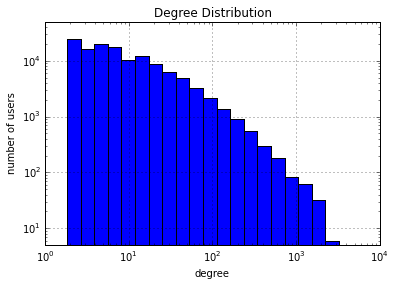

In [37]:
plot_degrees(degrees.degree, 5, 50000)

### Finding the number of users with at least one friend using degree info.

In [38]:
# A set containing users with at least one friend.
users2_set = set(degrees[degrees.degree > 0].user_id.values)

### Create new dataframes that are reduced using only above users.

In [39]:
# Create all dataframes that only have data with users with at least one friend.
# First, find users first.
user_df2 = user_df[user_df.apply(lambda x: x['user_id_int'] in users2_set, axis=1)]
# Second, find reviews done by these users.
review_df2 = review_df[review_df.apply(lambda x: x['user_id_int'] in users2_set, axis=1)]
# Lastly, find businesses that only these reviews are done for.
businesses2_set = set(review_df2.business_id_int.unique())
business_df2 = business_df[business_df.apply(lambda x: x['business_id_int'] in businesses2_set, axis=1)]

In [40]:
# Dataframe with the reviews (with business city).
review_city_df2 = business_df2[['business_id_int', 'business_city_int']]\
    .merge(review_df2, on=['business_id_int'], how='inner')

In [41]:
print user_df2.shape[0], business_df2.shape[0], review_df2.shape[0]

174094 59106 1143736


## Now doing above analyses with the reduced set.

In [42]:
# Reviews for three specific cities.
review_phoenix2 = review_city_df2[review_city_df2.business_city_int == 0].drop(['business_city_int'], axis=1)   # Phoenix
review_lasvegas2 = review_city_df2[review_city_df2.business_city_int == 1].drop(['business_city_int'], axis=1)  # Las Vegas
review_montreal2 = review_city_df2[review_city_df2.business_city_int == 3].drop(['business_city_int'], axis=1)  # Montreal

### Number of reviews per user

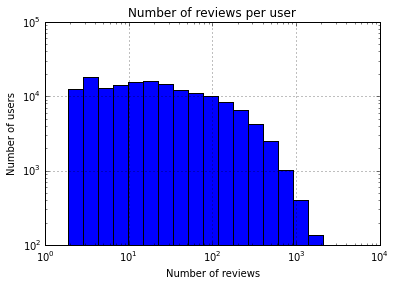

In [43]:
plt.ylim([100,100000])
plt.gca().set_xscale("log")
plt.yscale('log')
plt.title('Number of reviews per user')
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')
user_df2.user_review_count.hist(bins=np.logspace(0.1, 3.5, 20))

Looks different when number of reviews are small. Seems like users are more active overall.

### Number of reviews per business

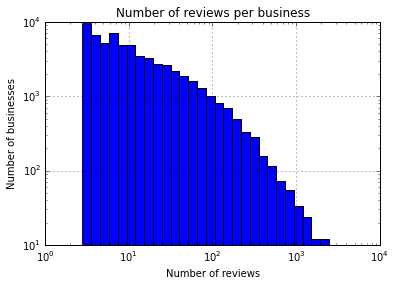

In [44]:
plt.ylim([10, 10000])
plt.gca().set_xscale("log")
plt.yscale('log')
plt.title('Number of reviews per business')
plt.xlabel('Number of reviews')
plt.ylabel('Number of businesses')
business_df.business_review_count.hist(bins=np.logspace(0.45, 3.5, 30))

Looks almost the same as before.

### Some counts per city

In [45]:
n_users2 = float(user_df2.shape[0])
n_businesses2 = float(business_df2.shape[0])
n_reviews2 = float(review_df2.shape[0])
users_by_city_ratio2 = np.array(review_city_df2.groupby('business_city_int').user_id_int.nunique()) / n_users2
businesses_by_city_ratio2 = np.array(review_city_df2.groupby('business_city_int').business_id_int.nunique()) / n_businesses2
reviews_by_city_ratio2 = np.array(review_city_df2.groupby('business_city_int').user_id_int.count()) / n_reviews2

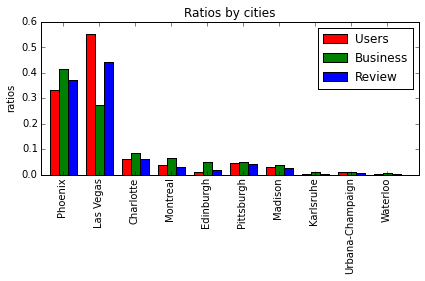

In [46]:
plot_counts(users_by_city_ratio2, businesses_by_city_ratio2, reviews_by_city_ratio2, 'Ratios by cities', 
            'ratios', ylim=0.6)
plt.tight_layout()
plt.savefig('../fig/ratios_by_city.png', dpi=200)

Overall trends are the same here.

Degree distribution should be the same as before, except users with degree zero.

In [47]:
cities_by_user2 = np.array(review_city_df2.groupby('user_id_int').business_city_int.nunique())

In [48]:
print sum(cities_by_user2 == 1) / float(n_users2),\
    sum(cities_by_user2 == 2) / float(n_users2),\
    sum(cities_by_user2 > 2) / float(n_users2)

0.920278700013 0.0714211862557 0.00830011373166


### User by city computed from 'find_users_by_city.py'.
Here it uses the network friends to determine the city if a user has reviews in multiple cities. If threre are ties between friends, it chooses the city randomly. As shown above, 92.1% of users have reviews in only one city, and 0.8% of users are chosen randomly, which means out of users with multiple cities, about 10% of them are chosen randomly. 

In [49]:
user_by_city = pd.read_csv('../data/user_by_city', names=['user_id', 'city'], header=None)
user_by_city.groupby('city').count()

,user_id
city,
0,52104
1,92761
2,9257
3,5270
4,1450
5,6928
6,4305
7,135
8,1507


### Looking at subnetworks for each city.

In [50]:
# Dataframes for each city.
degrees_subnet = []
for i in range(10):
    degrees_subnet.append(pd.read_csv('../data/degrees%s' % i, names=['user_id', 'degree'], header=None))

In [51]:
# Number of edges for all subgraphs.
nedges_subnet = []
for i in range(10):
    nedges_subnet.append(degrees_subnet[i].values.sum(axis=0)[1])
    print nedges_subnet[i]
print sum(nedges_subnet)

389936
1516460
43082
18657
9048
26391
13900
228
2652
522
2020876


In [52]:
# Number of edges for the total graph.
nedges = degrees.values.sum(axis=0)[1]
print nedges

2576179


In [53]:
# Percentage of edges that are connecting inside communities.
sum(nedges_subnet)/float(nedges)

0.78444704347019367

### Degree distributions for subnets for three cities.

### Phoenix

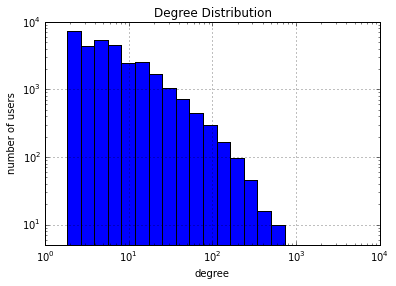

In [54]:
plot_degrees(degrees_subnet[0].degree, 5, 10000)
plt.savefig('../fig/degree_phoenix.png')

In [55]:
print degrees_subnet[0].degree.mean(), degrees_subnet[0].degree.median()

8.5645632454 3.0


### Las Vegas

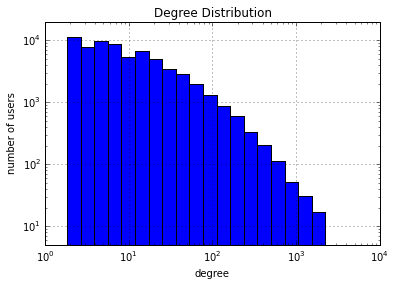

In [56]:
plot_degrees(degrees_subnet[1].degree, 5, 20000)
plt.savefig('../fig/degree_lasvegas.png')

In [57]:
print degrees_subnet[1].degree.mean(), degrees_subnet[1].degree.median()

17.2295631426 4.0


### Montreal

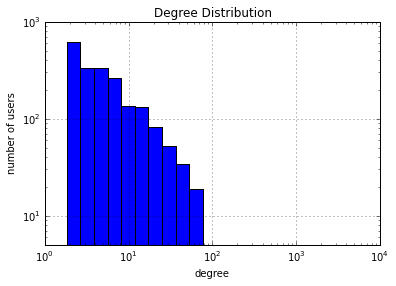

In [58]:
plot_degrees(degrees_subnet[3].degree, 5, 1000)
plt.savefig('../fig/degree_lasvegas.png')

In [59]:
print degrees_subnet[3].degree.mean(), degrees_subnet[3].degree.median()

5.41567489115 2.0


If we look at above results, three cities have quite different social networks. The avereage degrees are quite different. It is hard to find reasons why they are so different.

## Correlation between values.

### reviews per user and degrees per user

In [60]:
rev_count = user_df.user_review_count
deg_count = degrees.degree

In [61]:
from scipy.stats.stats import pearsonr

In [62]:
pearsonr(rev_count, deg_count)[0]

0.48288144800008354

As expected, the more active users are in terms of writing reviews, the more friends those users have. We can clearly see that when we look at those values together.

### Finding friends of friends for a network of a given city

In [64]:
city = 0
my_graph = read_dictlist_from_file('../data/network' + str(city) + '.csv')

In [65]:
friends_of_friends = {}
for node in my_graph:
    friends_of_friends[node] = set(my_graph[node])
    for friend1 in my_graph[node]:
        for friend2 in my_graph[friend1]:
            friends_of_friends[node].add(friend2)

In [66]:
nff = []
for user in friends_of_friends:
    nff.append(len(friends_of_friends[user]))

(array([  2.96650000e+04,   4.47800000e+03,   2.30600000e+03,
          1.49800000e+03,   9.99000000e+02,   6.46000000e+02,
          8.67000000e+02,   6.67000000e+02,   4.42000000e+02,
          3.46000000e+02,   2.69000000e+02,   4.71000000e+02,
          2.65000000e+02,   3.31000000e+02,   2.41000000e+02,
          2.27000000e+02,   2.04000000e+02,   1.62000000e+02,
          1.50000000e+02,   1.29000000e+02,   1.21000000e+02,
          1.07000000e+02,   7.80000000e+01,   9.30000000e+01,
          8.20000000e+01,   6.30000000e+01,   5.10000000e+01,
          4.10000000e+01,   5.40000000e+01,   4.40000000e+01,
          4.10000000e+01,   3.00000000e+01,   2.60000000e+01,
          3.70000000e+01,   2.20000000e+01,   2.10000000e+01,
          2.10000000e+01,   2.50000000e+01,   2.00000000e+01,
          1.60000000e+01,   1.70000000e+01,   1.10000000e+01,
          1.40000000e+01,   9.00000000e+00,   1.10000000e+01,
          1.30000000e+01,   1.10000000e+01,   6.00000000e+00,
        

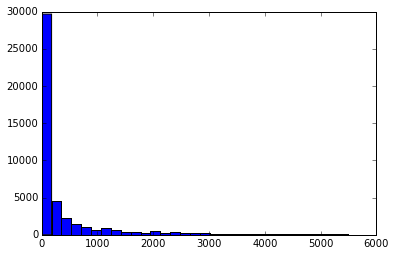

In [67]:
plt.xlim(0,6000)
plt.hist(nff, bins=100)

## Looking at all small networks (biggest components).

In [68]:
# Reading the biggest component of each graph for each city.
my_nets = []  # dict of lists
my_nets_nx = []  # networkx objects
for i in range(10):
    my_nets.append(reindex_graph(read_dictlist_from_file('../data/network' + str(i) + 'b.csv'))[0])
    my_nets_nx.append(convert_to_nx(my_nets[-1]))

### Number of average degrees.

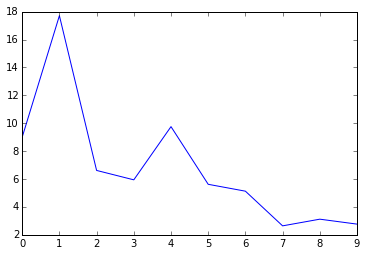

In [69]:
average_degrees = []
for i in range(10):
    average_degrees.append(np.mean(my_nets_nx[i].degree().values()))
plt.plot(average_degrees)

### Densities

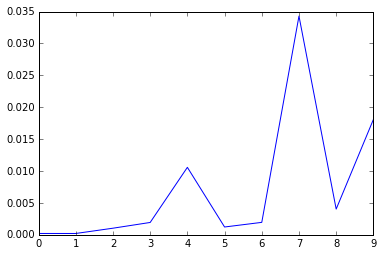

In [70]:
densities = []
for i in range(10):
    densities.append(nx.density(my_nets_nx[i]))
plt.plot(densities)

### Assortativities.

In [ ]:
assortativities = []
for i in range(10):
    assortativities.append(nx.degree_assortativity_coefficient(my_nets_nx[i]))
plt.plot(assortativities)

### Average clustering coefficients

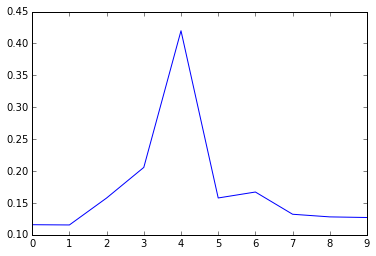

In [71]:
average_clusterings = []
for i in range(10):
    average_clusterings.append(nx.average_clustering(my_nets_nx[i]))
plt.plot(average_clusterings)

## Spectral clustering for cities.

In [ ]:
# Adjacency matrix for small cities (city number >= 2 only)
adjacency = []
for i in range(2, 10):
    adjacency.append(adjacency_matrix(my_nets[i]))

In [ ]:
spectral = []
for i in range(8):
    spectral.append(SpectralClustering(n_clusters=2, eigen_solver='arpack', affinity='precomputed',
                                       assign_labels='kmeans'))

In [ ]:
for i in range(8):
    spectral[i].fit(adjacency[i])

In [ ]:
n_communities = []
for i in range(5):
    n_communities.append((spectral[0].labels_ == i).sum())
plt.plot(n_communities)

In [ ]:
# Error distribution for matrix factorization case
errors = pd.read_csv('tt', header=None, names=['e'])
errors.e.hist(bins=30)

## Differences between real rating and predictions.

In [72]:
# Read the data for one run (processed to have real rating, average rating, rating by friends, rating by friends of
# friends, number of friends rated, number of friends of friends rated
# NaN will be given when there is no rating by friends and friends by friends.
rating_diff_df = pd.read_csv('../data/ratings_by_item2', delimiter=' ', names=['real', 'average', 'friend', 'friend2', 'nfr', 'nfr2'], header=None)

In [73]:
ratings_diff1 = rating_diff_df[['real', 'average', 'friend', 'nfr']].dropna()
ratings_diff2 = rating_diff_df[['real', 'average', 'friend2', 'nfr2']].dropna()

In [74]:
diff_ave1 = ratings_diff1.real - ratings_diff1.average
diff_ave2 = ratings_diff2.real - ratings_diff2.average

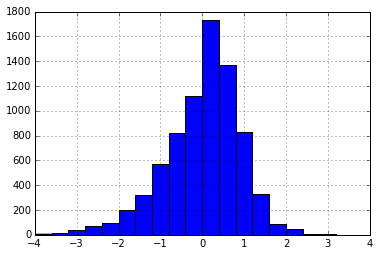

In [75]:
diff_ave1.hist(bins=20)

In [ ]:
diff_ave2.hist(bins=20)

In [76]:
print diff_ave1.std(), diff_ave2.std()

0.91056367396673188

In [79]:
diff_fr1 = rating_diff1.real - rating_diff1.friend
diff_fr1.hist(bins=20)

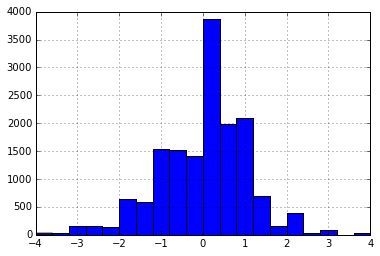

In [80]:
diff_fr2 = rating_diff2.real - rating_diff2.friend
diff_fr2.hist(bins=20)

In [77]:
stds1 = []
baseline1 = []
for n in range(1,100):
    diff_fr1 = ratings_diff1[ratings_diff1['nfr'] == n].real - \
               ratings_diff1[ratings_diff1['nfr'] == n].friend
    stds1.append(np.sqrt(np.mean(np.square(diff_fr1))))
    diff_av1 = ratings_diff1[ratings_diff1['nfr'] == n].real - \
               ratings_diff1[ratings_diff1['nfr'] == n].average
    baseline1.append(np.sqrt(np.mean(np.square(diff_av1))))

In [81]:
stds2 = []
baseline2 = []
for n in range(1,100):
    diff_fr2 = rating_diff2[rating_diff2['nfr2'] == n].real - \
               rating_diff2[rating_diff2['nfr2'] == n].friend2
    stds2.append(np.sqrt(np.mean(np.square(diff_fr2))))
    diff_av2 = ratings_diff2[ratings_diff2['nfr'] == n].real - \
               ratings_diff2[ratings_diff2['nfr'] == n].average
    baseline2.append(np.sqrt(np.mean(np.square(diff_av2))))

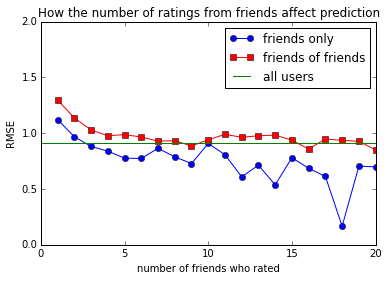

In [150]:
plt.xlabel('number of friends who rated')
plt.ylabel('RMSE')
plt.xlim(0,20)
plt.ylim(0,2)
plt.title('How the number of ratings from friends affect prediction')
fig1 = plt.plot(range(1,100), stds1, marker='o', color='g', label='friends only')
fig2 = plt.plot(range(1,100), stds2, marker='s', color='b', label='friends of friends')
fig3 = plt.plot(range(1,100), baseline1, marker='o', color='g', label='baseline for friends')
fig4 = plt.plot(range(1,100), baseline2, marker='s', color='b', label='baseline for friends of friends')
#fig3 = plt.plot([0, 100], [b1, b1], color='g', label='baseline for friends')
#fig4 = plt.plot([0, 100], [b2, b2], color='b', label='baseline for friends of friends')
plt.legend()
plt.savefig('../fig/friends.png', dpi=200)

In [129]:
# Baseline is already obtained for the whole ratings of the dataset, which is just the standard deviation
# of the all ratings. But this is not to be compared with results from UsingFriends, because they are using 
# subsets (one for each city) of the whole data. 
b = 1.3114679041155461

Baseline numbers for each city was obtained using Validator.get_baseline method. Here it computes the standard deviation for the given ratings of the training set.

In [131]:
ba_df = np.loadtxt('../data/baseline_each_city')

CF was run using (n_feasures=2, learning_rate=0.009, regularization_parameter=0.07) and K=10 with item bias considered (not user bias).

In [132]:
cf = np.loadtxt('../data/cf_rmse')

Using_Friends has been used to find the RMSE for the network-based model.

In [100]:
uf_df = np.loadtxt('../data/prel_results')#, delimiter=' ', names=['city', 'rmse'], header=None)

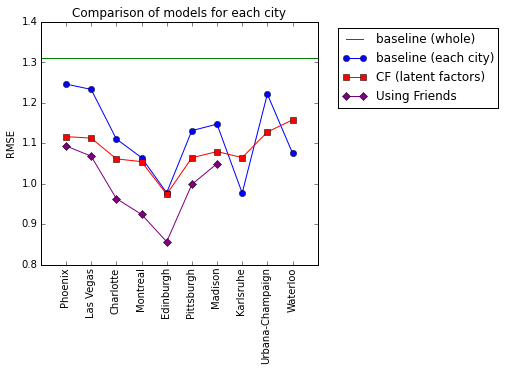

In [148]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.title('Comparison of models for each city')
plt.ylabel('RMSE')
plt.xlim(-1,10)
plt.ylim(0.8, 1.3)
ax.set_xticks(range(10))
xtickNames = ax.set_xticklabels(city_names)
plt.setp(xtickNames, rotation=90, fontsize=10)
ax.set_position([0.1,0.1,1.2,0.9])
#fig1 = plt.plot([-2, 100], [b, b], color='g', label='baseline (whole)')
fig2 = plt.plot(ba_df[:,0], ba_df[:,1], marker='s', color='purple', label='baseline (each city)')
fig3 = plt.plot(cf, marker='D', color='r', label='CF (latent factors)')
fig4 = plt.plot(uf_df[:,0], uf_df[:,1], marker='o', color='g', label='NF (using friends)*')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2 )
plt.tight_layout()
plt.savefig('../fig/rmse.png', dpi=200)

In [151]:
cf

array([ 1.1164795 ,  1.11277415,  1.06140494,  1.05461539,  0.97384244,
        1.06415573,  1.07947529,  1.06458209,  1.12783704,  1.15775142])

### How the lower limit for the number of ratings by friends changes the RMSE and the % of predicted.

In [26]:
# By running the model, results are produced already: city0_limit, city1_limit, city3_limit. 
limit0 = np.loadtxt('../fig/city0_limit')
limit1 = np.loadtxt('../fig/city1_limit')
limit3 = np.loadtxt('../fig/city3_limit')

Seems like their behavior is almost the same.

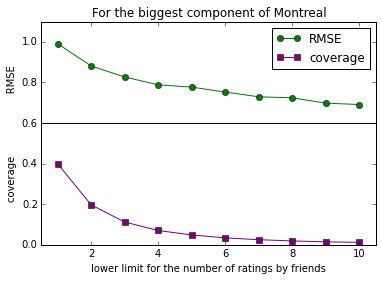

In [33]:

plt.title('For the biggest component of Montreal')
plt.ylim(0, 1.1)
plt.xlim(0.5,10.5)
plt.xlabel('lower limit for the number of ratings by friends')
plt.ylabel('coverage                    RMSE')
#plt.plot(limit0[:,0], limit0[:,1])
#plt.plot(limit1[:,0], limit1[:,1], marker='', color='b', label='Las Vegas')
plt.plot(limit3[:,0], limit3[:,2], marker='o', color='g', label='RMSE')
plt.plot(limit3[:,0], limit3[:,1], marker='s', color='purple', label='coverage')
plt.plot([0,11], [0.6,0.6], color='black')
#plt.plot(limit0[:,0], limit0[:,2])
#plt.plot(limit1[:,0], limit1[:,2])
plt.legend()
plt.savefig('../fig/limit.png', dpi=200)